### Import libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

import re
import math
import geopy

### Imports Dataset

In [81]:
airbnbData = pd.read_csv('./Data/Airbnb_Open_Data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Analyzing Data

### Checking dataset essentials

In [82]:
print("Shape: ", airbnbData.shape, "\n")

print("Columns: ", airbnbData.columns, "\n\n")

# Dropping columns that won't be usuful to model or has data leakage
droppingColumns = [
    'id', 'NAME', 'host id', 'host name', 'last review',
    'calculated host listings count', 'house_rules', 'license', 'availability 365',
    'country', 'neighbourhood' ,'country code', 'host_identity_verified']

airbnbData.drop(droppingColumns, axis =1 , inplace=True)

print("Null count before dropping:\n ",airbnbData.isnull().sum(), "\n\n")

# Drops all rows with a null value since the dataset is large
airbnbData = airbnbData.loc[airbnbData.isnull().sum(axis=1) == 0,:]
print("Shape after dropping:\n ", airbnbData.shape)
print("Null count after droping:\n ", airbnbData.isnull().sum())

airbnbData

Shape:  (102599, 26) 

Columns:  Index(['id', 'NAME', 'host id', 'host_identity_verified', 'host name',
       'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
       'country code', 'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'last review', 'reviews per month',
       'review rate number', 'calculated host listings count',
       'availability 365', 'house_rules', 'license'],
      dtype='object') 


Null count before dropping:
  neighbourhood group       29
lat                        8
long                       8
instant_bookable         105
cancellation_policy       76
room type                  0
Construction year        214
price                    247
service fee              273
minimum nights           409
number of reviews        183
reviews per month      15879
review rate number       326
dtype: int64 


Shape after dropping:
  (85355, 13)
Null coun

,neighbourhood group,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number
0,Brooklyn,40.64749,-73.97237,False,strict,Private room,2020.0,$966,$193,10.0,9.0,0.21,4.0
1,Manhattan,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,45.0,0.38,4.0
3,Brooklyn,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,$368,$74,30.0,270.0,4.64,4.0
4,Manhattan,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,$204,$41,10.0,9.0,0.10,3.0
5,Manhattan,40.74767,-73.97500,True,flexible,Entire home/apt,2013.0,$577,$115,3.0,74.0,0.59,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102588,Manhattan,40.74068,-73.98999,True,flexible,Entire home/apt,2016.0,$618,$124,1.0,177.0,3.78,4.0
102591,Manhattan,40.77408,-73.98181,False,strict,Entire home/apt,2005.0,"$1,139",$228,5.0,17.0,0.35,5.0
102593,Manhattan,40.72826,-73.98422,True,strict,Private room,2017.0,"$1,099",$220,1.0,8.0,0.16,4.0
102595,Manhattan,40.80460,-73.96545,True,moderate,Private room,2016.0,$837,$167,1.0,1.0,0.02,2.0


### Removing all none well rated posts

In [83]:
# Must have more than 4 star rating
# Must have more than 1 review per month
# Must have more than 20 reviews

print("Reviews per month mean: " ,airbnbData['reviews per month'].mean())
print("Number of reviews mean: " ,airbnbData['number of reviews'].mean())
print("Reviews rate mean: " , airbnbData['review rate number'].mean())

print("\nOriginal Shape: " ,airbnbData.shape)

airbnbData = airbnbData.loc[airbnbData['review rate number'] >= 4,:]

print("After a low score remvoving: " ,airbnbData.shape)

airbnbData = airbnbData.loc[airbnbData['number of reviews'] >= 10,:]

print("After removing number of reviews: " , airbnbData.shape)

airbnbData = airbnbData.loc[airbnbData['reviews per month'] >= 0.5,:]

print("After removing low monthly review rate dropping: " , airbnbData.shape)

# Drops review rows as they won't be used for training
airbnbData.drop(['review rate number', 'number of reviews', 'reviews per month'], inplace=True, axis=1)

#Reset the index

airbnbData.reset_index(inplace=True, drop=True)



Reviews per month mean:  1.3748053423935416
Number of reviews mean:  32.28347489895144
Reviews rate mean:  3.2801593345439635

Original Shape:  (85355, 13)
After a low score remvoving:  (38932, 13)
After removing number of reviews:  (20536, 13)
After removing low monthly review rate dropping:  (17746, 13)


In [84]:
airbnbData['neighbourhood group'].value_counts()

Brooklyn         7399
Manhattan        6633
Queens           2907
Bronx             567
Staten Island     239
brookln             1
Name: neighbourhood group, dtype: int64

### Converts string dollars to floats

In [85]:
dollarsColumns = ['price', 'service fee']

# Uses Regex to remove all none numeric characters
# Then converts the column to numeric values
for dolCol in dollarsColumns:  
    airbnbData[dolCol] = airbnbData[dolCol].apply(lambda x: re.sub(r'\D', '',x))
    airbnbData[dolCol] = pd.to_numeric(airbnbData[dolCol])

airbnbData[dollarsColumns]

,price,service fee
0,368,74
1,291,58
2,714,143
3,580,116
4,1010,202
...,...,...
17741,605,121
17742,985,197
17743,294,59
17744,77,15


### Getting the zipcode of locations

Finished getting all postal Info


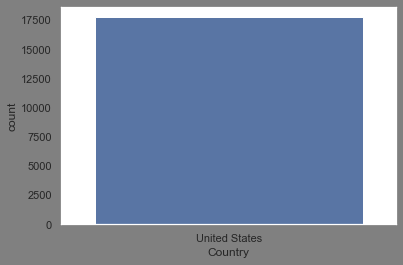

,PostalCode,Country
0,11238.0,United States
1,10025.0,United States
2,10036.0,United States
3,11215.0,United States
4,11211.0,United States
...,...,...
17744,11226.0,United States
17745,11215.0,United States
17746,11221.0,United States
17747,11221.0,United States


In [86]:
geolocator = geopy.Nominatim(user_agent="AirbnbReactWebsite")

postalInfoDf = pd.read_csv('./Data/PostalInfo.csv')


for i,x in airbnbData.iterrows():
    
    if i < len(postalInfoDf.index):
        continue
    
    location = geolocator.reverse((x.lat, x.long))
    locationRaw = location.raw['display_name'].split(', ')
    
    postalCode =  [locationRaw[-2], locationRaw[-1]]
    
    print(i, "/" , airbnbData.shape[0] ,': ', postalCode)
    
    postalInfoDf.loc[i] = postalCode
    
    if i %100 == 0:
        postalInfoDf.to_csv('./Data/PostalInfo.csv' ,index=False)
        

        
# Coverts all postal codes to int
#postalInfoDf['PostalCode'] = postalInfoDf['PostalCode'].apply(lambda x: re.sub(r'\D', '',x))
#postalInfoDf['PostalCode'] = pd.to_numeric(postalInfoDf['PostalCode'])


postalInfoDf.to_csv('./Data/PostalInfo.csv' ,index=False)
print('Finished getting all postal Info')

# don't need lat and long since we have the zipcodes
#wairbnbData.drop(['lat', 'long'], inplace=True, axis=1)

sns.countplot(data = postalInfoDf, x='Country')

plt.show()
    
postalInfoDf



### Getting the Area Deprivation of zipcodes

In [87]:
#Puts postal code into the airbnb dataframe
airbnbData['PostalCode'] = postalInfoDf['PostalCode']

# Imports the area deprivation 
areaDep = pd.read_csv('./Data/areaDeprivation.csv')

AREA_DEP_AVG = 59.1840345821315

# Gets the corresponding area dep for the zipcode
areaDepArr = []
for i,x in airbnbData.iterrows():
    code = x.PostalCode
    # Gets all the rows with the same zipcode
    areaDepRows = areaDep.loc[areaDep['zipcode'] == code, :]
    # Takes a mean of all the rows
    areaMean =areaDepRows['areaDeprivation'].mean()
    
    if math.isnan(areaMean):
        areaDepArr.append(AREA_DEP_AVG)
    else:
        areaDepArr.append(areaMean)
# Adds area Dep to the array
airbnbData['AreaDeprivation'] = areaDepArr

# Drops postal code as it isn't needed anymore
airbnbData.drop('PostalCode', inplace=True, axis=1)

airbnbData

    

,neighbourhood group,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,AreaDeprivation
0,Brooklyn,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,368,74,30.0,28.333333
1,Manhattan,40.80178,-73.96723,False,strict,Private room,2015.0,291,58,2.0,25.333333
2,Manhattan,40.76076,-73.98867,False,strict,Private room,2008.0,714,143,2.0,15.000000
3,brookln,40.66829,-73.98779,True,moderate,Private room,2010.0,580,116,4.0,5.000000
4,Manhattan,40.71401,-73.98917,True,moderate,Shared room,2012.0,1010,202,1.0,64.333333
...,...,...,...,...,...,...,...,...,...,...,...
17741,Brooklyn,40.65452,-73.95960,False,flexible,Private room,2020.0,605,121,2.0,28.333333
17742,Brooklyn,40.66880,-73.97865,False,flexible,Private room,2013.0,985,197,1.0,2.000000
17743,Brooklyn,40.68740,-73.93830,True,strict,Entire home/apt,2009.0,294,59,3.0,93.666667
17744,Brooklyn,40.68742,-73.92825,False,flexible,Private room,2022.0,77,15,2.0,86.000000


# Visualizing Data

In [88]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'gray'})

### Visualizing Area Dep

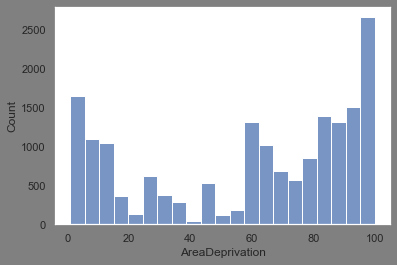

In [89]:
sns.histplot(data = airbnbData, x='AreaDeprivation')

plt.show()

### Visualizing Room Type

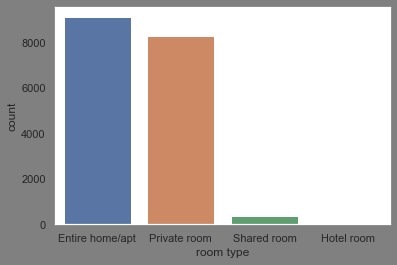

In [90]:
sns.countplot(data = airbnbData, x='room type')

plt.show()

### Visualizing Instant Bookable

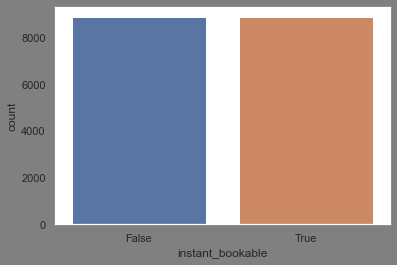

In [91]:
sns.countplot(data = airbnbData, x='instant_bookable')

plt.show()

### Visualizing Cancelation Policy

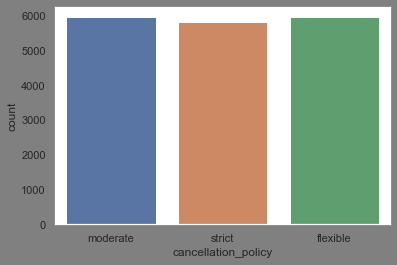

In [92]:
sns.countplot(data = airbnbData, x='cancellation_policy')

plt.show()

### Oridinal Encoding

In [93]:
airbnbData['cancellation_policy'] = airbnbData['cancellation_policy'].map(
    {'strict': 0, 'moderate': 1, 'flexible': 2}
)

airbnbData['instant_bookable'] = airbnbData['instant_bookable'].map(
    {False: 0, True: 1}
)

airbnbData['room type'] = airbnbData['room type'].map(
    {'Entire home/apt': 2, 'Private room': 1, 'Shared room': 0, 'Hotel room': 1}
)

airbnbData

,neighbourhood group,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,AreaDeprivation
0,Brooklyn,40.68514,-73.95976,1,1,2,2005.0,368,74,30.0,28.333333
1,Manhattan,40.80178,-73.96723,0,0,1,2015.0,291,58,2.0,25.333333
2,Manhattan,40.76076,-73.98867,0,0,1,2008.0,714,143,2.0,15.000000
3,brookln,40.66829,-73.98779,1,1,1,2010.0,580,116,4.0,5.000000
4,Manhattan,40.71401,-73.98917,1,1,0,2012.0,1010,202,1.0,64.333333
...,...,...,...,...,...,...,...,...,...,...,...
17741,Brooklyn,40.65452,-73.95960,0,2,1,2020.0,605,121,2.0,28.333333
17742,Brooklyn,40.66880,-73.97865,0,2,1,2013.0,985,197,1.0,2.000000
17743,Brooklyn,40.68740,-73.93830,1,0,2,2009.0,294,59,3.0,93.666667
17744,Brooklyn,40.68742,-73.92825,0,2,1,2022.0,77,15,2.0,86.000000


### One Hot Encoding

In [94]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

oneHot_train = pd.DataFrame(OH_encoder.fit_transform(airbnbData[['neighbourhood group']]))

oneHot_train.columns = OH_encoder.get_feature_names_out()

airbnbData.reset_index(drop=True, inplace=True)
oneHot_train.reset_index(drop=True, inplace=True)

airbnbData = pd.concat([airbnbData, oneHot_train], axis=1)

airbnbData.drop('neighbourhood group', axis=1, inplace=True)

airbnbData

,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,AreaDeprivation,neighbourhood group_Bronx,neighbourhood group_Brooklyn,neighbourhood group_Manhattan,neighbourhood group_Queens,neighbourhood group_Staten Island,neighbourhood group_brookln
0,40.68514,-73.95976,1,1,2,2005.0,368,74,30.0,28.333333,0.0,1.0,0.0,0.0,0.0,0.0
1,40.80178,-73.96723,0,0,1,2015.0,291,58,2.0,25.333333,0.0,0.0,1.0,0.0,0.0,0.0
2,40.76076,-73.98867,0,0,1,2008.0,714,143,2.0,15.000000,0.0,0.0,1.0,0.0,0.0,0.0
3,40.66829,-73.98779,1,1,1,2010.0,580,116,4.0,5.000000,0.0,0.0,0.0,0.0,0.0,1.0
4,40.71401,-73.98917,1,1,0,2012.0,1010,202,1.0,64.333333,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17741,40.65452,-73.95960,0,2,1,2020.0,605,121,2.0,28.333333,0.0,1.0,0.0,0.0,0.0,0.0
17742,40.66880,-73.97865,0,2,1,2013.0,985,197,1.0,2.000000,0.0,1.0,0.0,0.0,0.0,0.0
17743,40.68740,-73.93830,1,0,2,2009.0,294,59,3.0,93.666667,0.0,1.0,0.0,0.0,0.0,0.0
17744,40.68742,-73.92825,0,2,1,2022.0,77,15,2.0,86.000000,0.0,1.0,0.0,0.0,0.0,0.0


### Reformating Variables

In [95]:
#makes it a decimal between 0 and 1
airbnbData['AreaDeprivation'] = airbnbData['AreaDeprivation'].apply(lambda x: x/100)

#Reduces construction year to smaller number
minConstruction = airbnbData['Construction year'].min()
airbnbData['Construction year'] = airbnbData['Construction year'].apply(lambda x: x - minConstruction)

#Reduces lat to smaller number
minLat = airbnbData['lat'].min()
airbnbData['lat'] = airbnbData['lat'].apply(lambda x: x - minLat)

#Reduces long to a smaller number
minLong = airbnbData['long'].min()
airbnbData['long'] = airbnbData['long'].apply(lambda x: x - minLong)

print(airbnbData.info())

airbnbData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17746 entries, 0 to 17745
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   lat                                17746 non-null  float64
 1   long                               17746 non-null  float64
 2   instant_bookable                   17746 non-null  int64  
 3   cancellation_policy                17746 non-null  int64  
 4   room type                          17746 non-null  int64  
 5   Construction year                  17746 non-null  float64
 6   price                              17746 non-null  int64  
 7   service fee                        17746 non-null  int64  
 8   minimum nights                     17746 non-null  float64
 9   AreaDeprivation                    17746 non-null  float64
 10  neighbourhood group_Bronx          17746 non-null  float64
 11  neighbourhood group_Brooklyn       17746 non-null  flo

,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,AreaDeprivation,neighbourhood group_Bronx,neighbourhood group_Brooklyn,neighbourhood group_Manhattan,neighbourhood group_Queens,neighbourhood group_Staten Island,neighbourhood group_brookln
0,0.14643,0.25112,1,1,2,2.0,368,74,30.0,0.283333,0.0,1.0,0.0,0.0,0.0,0.0
1,0.26307,0.24365,0,0,1,12.0,291,58,2.0,0.253333,0.0,0.0,1.0,0.0,0.0,0.0
2,0.22205,0.22221,0,0,1,5.0,714,143,2.0,0.150000,0.0,0.0,1.0,0.0,0.0,0.0
3,0.12958,0.22309,1,1,1,7.0,580,116,4.0,0.050000,0.0,0.0,0.0,0.0,0.0,1.0
4,0.17530,0.22171,1,1,0,9.0,1010,202,1.0,0.643333,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17741,0.11581,0.25128,0,2,1,17.0,605,121,2.0,0.283333,0.0,1.0,0.0,0.0,0.0,0.0
17742,0.13009,0.23223,0,2,1,10.0,985,197,1.0,0.020000,0.0,1.0,0.0,0.0,0.0,0.0
17743,0.14869,0.27258,1,0,2,6.0,294,59,3.0,0.936667,0.0,1.0,0.0,0.0,0.0,0.0
17744,0.14871,0.28263,0,2,1,19.0,77,15,2.0,0.860000,0.0,1.0,0.0,0.0,0.0,0.0


# Model Training

### Importing models

In [96]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

### Train Test Split

In [97]:
yPrice = airbnbData['price']
yService = airbnbData['service fee']
airbnbData.drop(['price', 'service fee'], axis=1, inplace=True)
X_trainP, X_validP, y_trainP, y_validP = train_test_split(airbnbData, yPrice, random_state = 42, shuffle=True)
X_trainS, X_validS, y_trainS, y_validS = train_test_split(airbnbData, yService, random_state = 42, shuffle=True)

### Service Fee Vs Price Graph

<function matplotlib.pyplot.show(*args, **kw)>

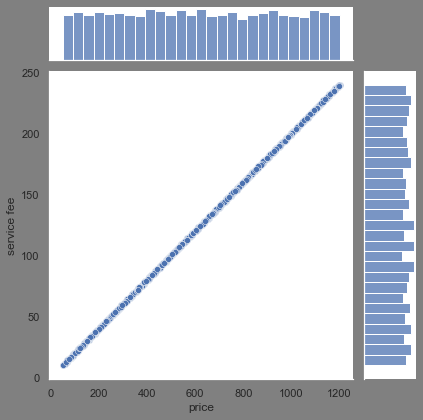

In [98]:
sns.jointplot(x=yPrice, y=yService)

plt.show

### Training Price Model

In [102]:
print("Price Details:\n",yPrice.describe(), "\n")

priceModels = {
    "XGBoost": XGBRegressor(
        n_estimators=10000, 
        early_stopping_rounds=100,
        learning_rate = 0.1
    ),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_leaf_nodes=750)
}


for name,priceModel in priceModels.items(): 
    if name == 'XGBoost':
        priceModel.fit(X_trainP, y_trainP, eval_set=[(X_validP, y_validP)], verbose=False)
    else:
        priceModel.fit(X_trainP, y_trainP)
        
    pricePred = priceModel.predict(X_validP)

    print(name, "Price Mean Absolute Error: " + str(mean_absolute_error(pricePred, y_validP)))

Price Details:
 count    17746.000000
mean       624.202412
std        331.608855
min         50.000000
25%        338.000000
50%        620.000000
75%        912.000000
max       1200.000000
Name: price, dtype: float64 

XGBoost Price Mean Absolute Error: 228.07568999698415
Linear Regression Price Mean Absolute Error: 288.98604871187456
Random Forest Price Mean Absolute Error: 284.58282623394183


### Training Service Model

In [103]:
print("Service Details:\n", yService.describe(), "\n")

serviceModels = {
    "XGBoost": XGBRegressor(
        n_estimators=10000, 
        early_stopping_rounds=100,
        learning_rate = 0.1
    ),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_leaf_nodes=750)
}


for name,serviceModel in serviceModels.items(): 
    if name == 'XGBoost':
        serviceModel.fit(X_trainS, y_trainS, eval_set=[(X_validS, y_validS)], verbose=False)
    else:
        serviceModel.fit(X_trainS, y_trainS)
        
    servicePred = serviceModel.predict(X_validS)

    print(name, "Service Mean Absolute Error: " + str(mean_absolute_error(servicePred, y_validS)))
    


Service Details:
 count    17746.000000
mean       124.840640
std         66.323405
min         10.000000
25%         68.000000
50%        124.000000
75%        182.000000
max        240.000000
Name: service fee, dtype: float64 

XGBoost Service Mean Absolute Error: 46.883358858231894
Linear Regression Service Mean Absolute Error: 57.79864937395307
Random Forest Service Mean Absolute Error: 57.939824205544284
